In [1]:
# read the data in

import pandas as pd
import numpy as np
import sys

def exit_with_error(message):
    print(f"Error: {message}")
    sys.exit(1)

metadata_fname = "data\\unblinded-augmented-metadata_wide_tic.tsv"
quants_fname = "data\\precursors_wide_unnormalized.tsv"

metadata = pd.read_csv(metadata_fname, sep='\t', na_values=['na'])
data = pd.read_csv(quants_fname, sep='\t')
data = data.fillna(0)
protein_names = data['protein'].values
peptides = data['modifiedSequence'].values

print("Metadata shape:", metadata.shape)
print("Data shape:", data.shape)

Metadata shape: (288, 26)
Data shape: (773, 294)


Data shape: (217, 773)
Doses: [ 0.   9.2  9.3  9.4  9.5  9.7  9.8 23.  23.1 23.5 23.7 23.8 23.9 24.
 24.1 24.2 24.3 69.6 70.5 70.6 70.9 71.  71.1 71.5 71.6 72.1 72.8 73.2
 73.3 93.1 94.7 95.2 97.5]
Focus Areas: ['FA1' 'FA2']
trex batches: [17. 18. 19. 20. 22. 23.]
['FA1' 'FA2' 'FA1' 'FA2' 'FA2' 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2'
 'FA1' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2' 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1'
 'FA1' 'FA2' 'FA2' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2' 'FA2' 'FA1'
 'FA1' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2' 'FA1' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1'
 'FA2' 'FA1' 'FA2' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2' 'FA2' 'FA1' 'FA2'
 'FA1' 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA1' 'FA2' 'FA1' 'FA2' 'FA1'
 'FA1' 'FA1' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1'
 'FA2' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2' 'FA2' 'FA2' 'FA1' 'FA1' 'FA2'
 'FA1' 'FA1' 'FA2' 'FA2' 'FA1' 'FA2' 'FA2' 'FA1' 'FA1' 'FA1' 'FA2' 'FA1'
 'FA2' 'FA1' 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2' 'FA1' 'FA2' 'FA2'
 'FA2

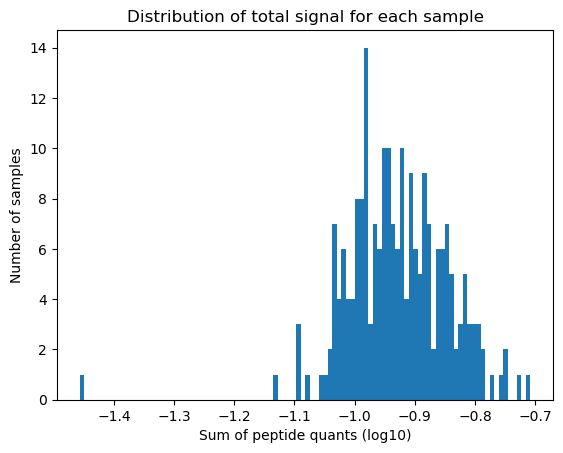

In [2]:
# transform data into what Justin's code is expecting

import matplotlib.pyplot as plt

valid_replicates = metadata[
    (metadata['Radiation Dose(cGy)'].notna())
]['replicate'].tolist()


X = []
rad = []
fa = []
tse = []
trex_batch = []
tic = []

for idx in valid_replicates:
    for sample in data.columns[:]:
        if idx in sample:
            # Get the metadata row for this replicate
            meta_row = metadata[metadata['replicate'] == idx]
            
            s_rad = meta_row['Radiation Dose(cGy)'].values[0]
            s_fa = meta_row['Focus_Area'].values[0]
            s_tse = meta_row['daysaftertreatment'].values[0]
            s_batch = meta_row['batch'].values[0]
            s_tic = meta_row['TicArea'].values[0]
            
            # Convert to int only if it's not NA
            rad.append(s_rad)
            fa.append(s_fa)
            tse.append(s_tse)
            trex_batch.append(s_batch)
            tic.append(s_tic)
            
            X.append(data[sample].values)

X = np.array(X)
rad = np.array(rad)
fa = np.array(fa)
trex_batch = np.array(trex_batch)
tse = np.array(tse)
tic = np.array(tic)

normalized_X = X / tic[:, np.newaxis]
X = normalized_X

print("Data shape:", X.shape)
print("Doses:", np.unique(rad))
print("Focus Areas:", np.unique(fa))
print("trex batches:", np.unique(trex_batch))

print(fa)
print(trex_batch)
print(rad)
total_signal = np.sum(X, axis=1)
plt.hist(np.log10(total_signal), bins=100)
plt.title('Distribution of total signal for each sample')
plt.ylabel('Number of samples')
plt.xlabel('Sum of peptide quants (log10)')
plt.show()

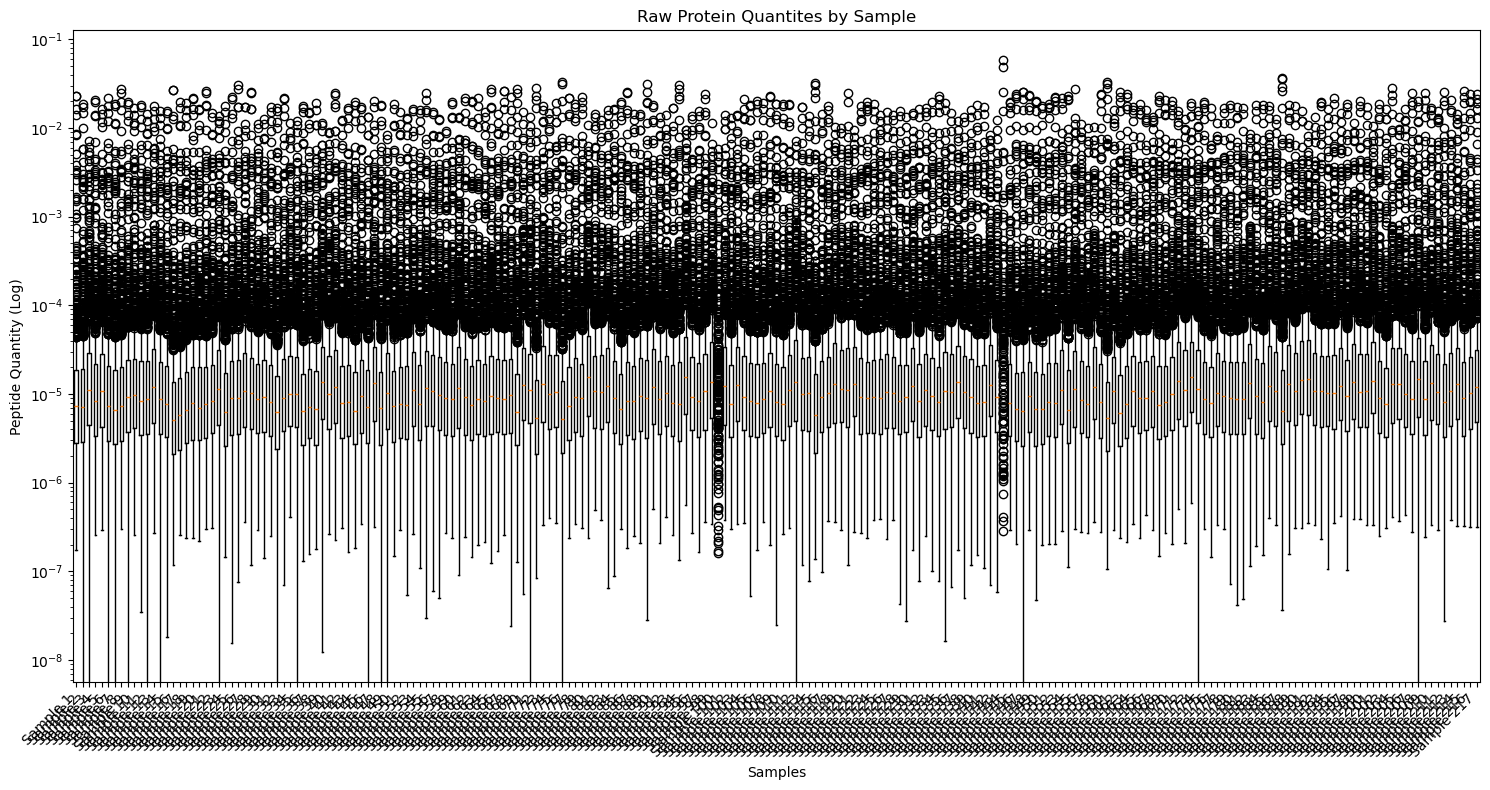

In [3]:
# Create the box plot
plt.figure(figsize=(15, 8))
plt.boxplot(X.T)  # Transpose the data

plt.title('Raw Protein Quantites by Sample')
plt.xlabel('Samples')
plt.ylabel('Peptide Quantity (Log)')
plt.xticks(range(1, X.shape[0] + 1), [f'Sample {i+1}' for i in range(X.shape[0])], rotation=45, ha='right')

# Use log scale for y-axis as peptide quantities often span several orders of magnitude
plt.yscale('log')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

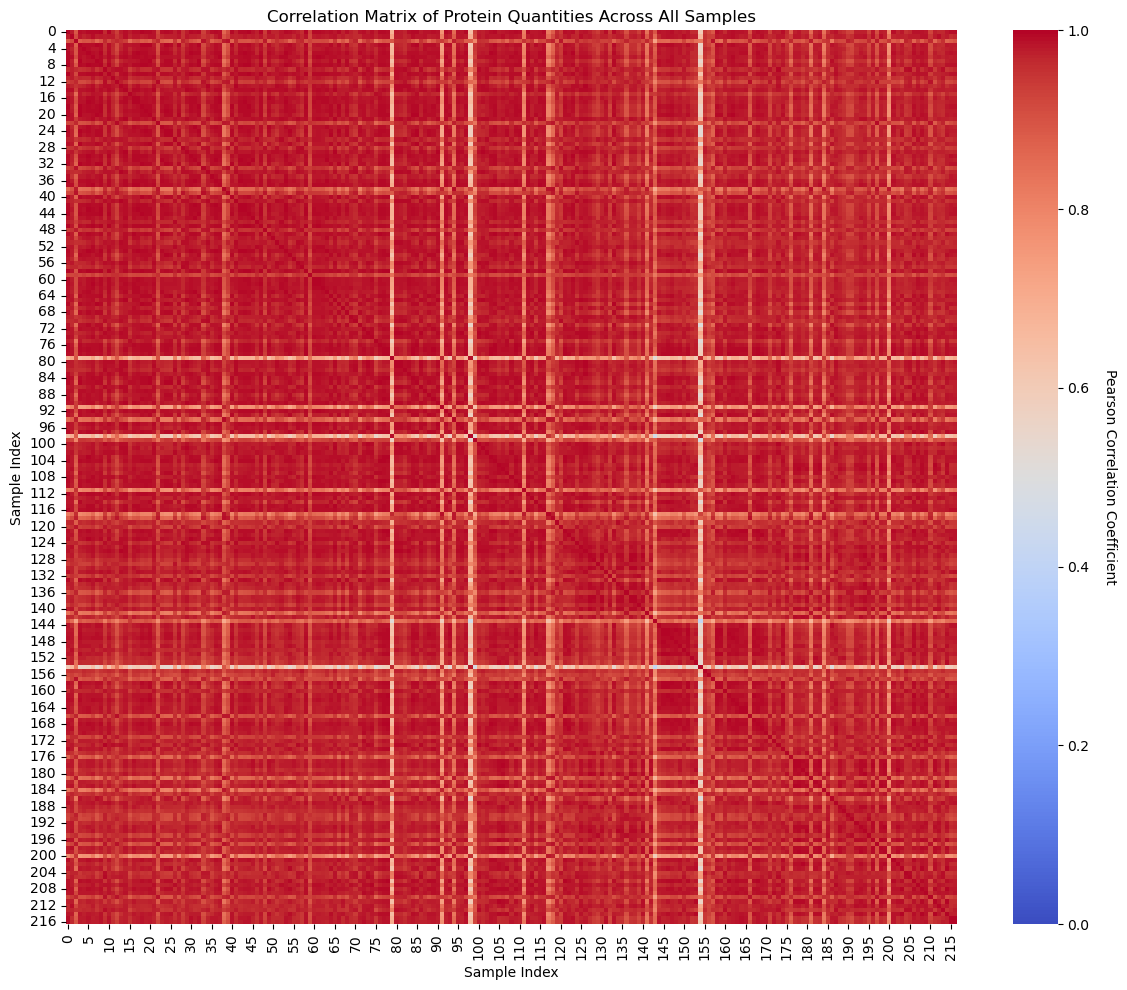

Number of samples: 217
Number of proteins: 773
Using unlogged values
Average correlation (excluding self-correlations): 0.9481


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_protein_correlation_matrix(unlogged_X, use_log=True, save_path=None):
    """
    Create a correlation matrix heatmap comparing protein quantities across all samples.
    
    Parameters:
    unlogged_X (np.array): 2D array with samples as rows, proteins as columns, and quantities as values
    use_log (bool, optional): Whether to use log-transformed values for protein quantities. Defaults to True.
    save_path (str, optional): Path to save the plot. If None, the plot will be displayed instead.
    
    Returns:
    np.array: The correlation matrix
    """
    
    # Apply log transformation if use_log is True
    tmpX = np.log2(unlogged_X) if use_log else unlogged_X
    
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(tmpX)
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0.5, vmin=0, vmax=1)
    
    plt.title('Correlation Matrix of Protein Quantities Across All Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    
    # Add colorbar label
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Pearson Correlation Coefficient', rotation=270, labelpad=20)
    
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
    
    # Print summary statistics
    print(f"Number of samples: {tmpX.shape[0]}")
    print(f"Number of proteins: {tmpX.shape[1]}")
    print(f"Using {'log-transformed' if use_log else 'unlogged'} values")
    
    # Calculate and print the average correlation, excluding self-correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    upper_triangle = corr_matrix[mask]
    average_correlation = np.mean(upper_triangle)
    print(f"Average correlation (excluding self-correlations): {average_correlation:.4f}")
    
    return corr_matrix

corr_matrix = plot_protein_correlation_matrix(X, use_log=False)

[22. 18. 22. 18. 18. 22. 18. 18. 20. 18. 22. 20. 22. 20. 18. 20. 19. 20.
 22. 18. 20. 18. 20. 22. 19. 18. 20. 20. 22. 22. 17. 22. 17. 20. 18. 17.
 17. 20. 20. 20. 22. 20. 22. 18. 23. 17. 23. 17. 20. 23. 20. 20. 17. 23.
 17. 19. 20. 20. 19. 18. 17. 17. 18. 20. 18. 20. 22. 22. 20. 19. 18. 17.
 19. 17. 18. 23. 17. 22. 17. 20. 17. 23. 17. 19. 20. 20. 20. 18. 20. 17.
 18. 20. 20. 17. 19. 20. 17. 22. 20. 20. 17. 18. 18. 23. 22. 17. 20. 17.
 18. 17. 22. 18. 20. 18. 18. 19. 20. 22. 18. 20. 20. 17. 20. 23. 17. 22.
 20. 17. 18. 20. 17. 22. 20. 17. 18. 19. 18. 22. 17. 18. 20. 20. 20. 17.
 18. 19. 20. 20. 22. 19. 18. 20. 17. 17. 20. 23. 17. 17. 19. 17. 17. 19.
 20. 18. 22. 18. 20. 17. 18. 18. 18. 20. 17. 18. 19. 22. 18. 17. 17. 17.
 20. 18. 23. 17. 18. 20. 20. 17. 18. 18. 17. 18. 19. 20. 18. 20. 22. 20.
 20. 22. 20. 22. 19. 19. 20. 18. 18. 19. 19. 18. 18. 17. 20. 20. 19. 17.
 17.]
[22. 22. 22. 22. 22. 19. 22. 22. 19. 22. 22. 17. 22. 17. 17. 17. 22. 22.
 23. 17. 23. 17. 23. 17. 23. 17. 19. 19. 17. 

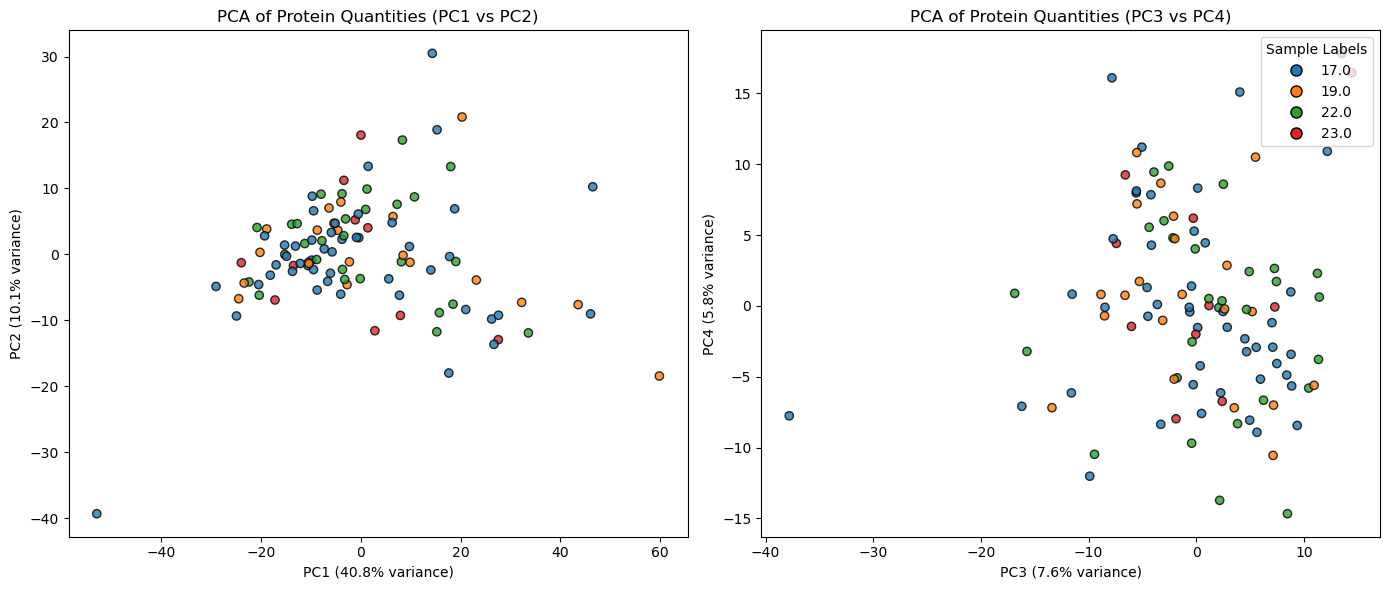

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Assume your data:
# X: 2D NumPy array (samples x proteins)
# labels: 1D NumPy array (categorical labels for each sample)

# Create mask for filtering
mask = [(f == 'FA1') for r, f, b in zip(rad, fa, trex_batch)]
print(trex_batch)
filtered_labels = trex_batch[mask]
print(filtered_labels)
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[mask])

# Perform PCA with 4 components to capture PC3 and PC4
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratios
explained_var = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Assign unique colors to categorical labels
unique_labels = np.unique(filtered_labels)
label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
colors = [label_to_color[label] for label in filtered_labels]

# Use a high-contrast colormap
cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])

# Create PCA plots with white background
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax in axes:
    ax.set_facecolor('white')  # Ensure no grey background

# PC1 vs PC2 plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap=cmap, edgecolor='k', alpha=0.8)
axes[0].set_xlabel(f"PC1 ({explained_var[0]:.1f}% variance)")
axes[0].set_ylabel(f"PC2 ({explained_var[1]:.1f}% variance)")
axes[0].set_title("PCA of Protein Quantities (PC1 vs PC2)")

# Create legend for PC1 vs PC2 plot
handles = [plt.Line2D([0], [0], marker='o', linestyle='', markersize=8, markerfacecolor=cmap(idx), markeredgecolor='k') 
           for idx in range(len(unique_labels))]

# PC3 vs PC4 plot
scatter2 = axes[1].scatter(X_pca[:, 2], X_pca[:, 3], c=colors, cmap=cmap, edgecolor='k', alpha=0.8)
axes[1].set_xlabel(f"PC3 ({explained_var[2]:.1f}% variance)")
axes[1].set_ylabel(f"PC4 ({explained_var[3]:.1f}% variance)")
axes[1].set_title("PCA of Protein Quantities (PC3 vs PC4)")
axes[1].legend(handles, unique_labels, title="Sample Labels", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict, Union
import warnings

def crossvalidate_binary_logistic(
    labeled_X: np.ndarray, 
    y: np.ndarray, 
    param: Dict[str, Union[str, float, int]],
    title: str = "Logistic Regression ROC Curve",
    random_state: int = 1966
) -> Tuple[List[float], List[float], np.ndarray]:
    """
    Perform repeated k-fold cross-validation for binary logistic regression with regularization.
    Features are standardized within each fold to prevent data leakage.
    
    Args:
        labeled_X: Feature matrix
        y: Target vector
        param: Dictionary of parameters for LogisticRegression
        title: Plot title
        random_state: Random seed for reproducibility
                       
    Returns:
        Tuple of:
            - List of training accuracies (percent)
            - List of test accuracies (percent)
            - Numpy array of summed coefficients for each feature across all folds
    """
    print("Baseline Accuracy:", sum(y)/len(y))
    
    # Set default parameters if not provided
    default_params = {
        'C': 1.0,
        'penalty': 'elasticnet',
        'l1_ratio': 0.5,
        'solver': 'saga',
        'max_iter': 5000,
        'random_state': random_state,
        'warm_start': True,
        'tol': 1e-4,
    }
    
    # Update defaults with provided parameters
    model_params = {**default_params, **param}
    
    # Keep track of convergence
    convergence_failures = 0
    total_folds = 50  # 10 splits * 5 repeats = 50 total folds
    
    # Convert inputs to numpy arrays if they aren't already
    labeled_X = np.array(labeled_X)
    y = np.array(y)
    
    # Create figures for ROC curve
    fig, ax = plt.subplots(figsize=(6, 6))
    _, garbage_ax = plt.subplots(figsize=(6, 6))  # Temporary figure for individual curves
    
    # Initialize lists to store results
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 1000)
    train_accs = []
    test_accs = []
    
    # To accumulate coefficients
    coef_sums = np.zeros(labeled_X.shape[1])
    
    # Set up cross-validation
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
    
    # Suppress the specific convergence warning
    with warnings.catch_warnings(record=True) as w:
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        
        # Perform cross-validation
        for train, test in skf.split(labeled_X, y):
            X_train, X_test = labeled_X[train], labeled_X[test]
            y_train, y_test = y[train], y[test]
            
            # Scale features using only training data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train logistic regression model
            model = LogisticRegression(**model_params)
            model.fit(X_train_scaled, y_train)
            
            # Check convergence
            if not model.n_iter_ < model_params['max_iter']:
                convergence_failures += 1
            
            # Get predictions and probabilities
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            test_prob = model.predict_proba(X_test_scaled)[:, 1]
            
            # Calculate accuracies
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            train_accs.append(train_acc * 100)
            test_accs.append(test_acc * 100)
            
            # Add coefficients from this fold to the sum
            coef_sums += model.coef_[0]
            
            # Calculate ROC curve on temporary axis
            viz = RocCurveDisplay.from_predictions(
                y_test,
                test_prob,
                ax=garbage_ax
            )
            
            # Interpolate TPR
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
            
            # Clear the temporary plot
            garbage_ax.clear()
    
    # Report convergence status
    if convergence_failures > 0:
        print(f"\nWarning: {convergence_failures}/{total_folds} folds did not achieve convergence.")
        print("Consider one or more of these solutions:")
        print(f"1. Increase max_iter (currently {model_params['max_iter']})")
        print(f"2. Increase tol (currently {model_params['tol']})")
        print(f"3. Decrease C (currently {model_params['C']}) to reduce model complexity")
        print()
    
    # Plot styling
    plt.style.use('ggplot')
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
    
    # Calculate and plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        lw=2,
        alpha=0.8,
    )
    
    # Add standard deviation band
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label="±1 std. dev.",
    )
    
    # Configure plot
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title
    )
    ax.axis("square")
    
    # Clean up legend
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[-2:]
    labels = labels[-2:]
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="lower right")
    
    # Remove the temporary figure
    plt.close(garbage_ax.figure)
    
    plt.show()
    
    print(f"Average Train Accuracy: {np.mean(train_accs):.2f}% ± {np.std(train_accs):.2f}%")
    print(f"Average Test Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    
    return train_accs, test_accs, coef_sums

[ 0.  73.3 72.8 70.9  0.  23.1 73.2  9.3 70.5 72.8  0.   9.8 72.8  9.3
  9.3  0.  24.2  9.8  0.   0.   0.  73.2  9.3  9.7 70.9  0.  97.5  9.7
  0.   0.  71.6 23.9 72.8 70.9  9.8]
[True, False, False, False, True, True, False, True, False, False, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, True, False, True, False, False, True]
(35, 773) 35 22
Baseline Accuracy: 0.6285714285714286


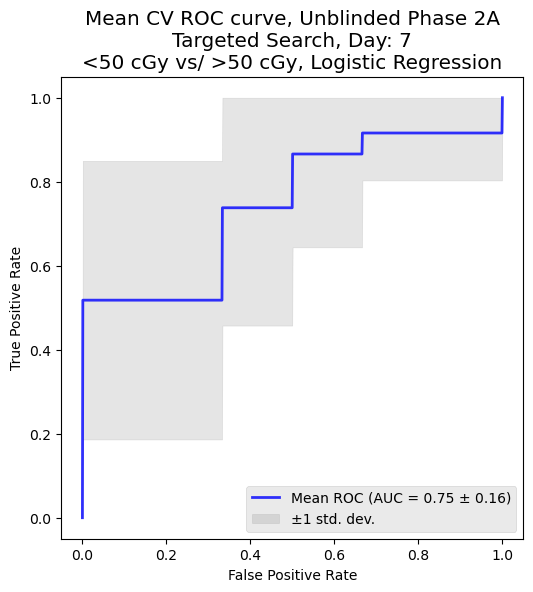

Average Train Accuracy: 100.00% ± 0.00%
Average Test Accuracy: 73.14% ± 16.82%


In [7]:
from sklearn.preprocessing import OneHotEncoder

# FA1 batches: 17 19 22 23
# FA2 batches: 18 20

# Time since exposure (days): [  6.   7.  14.  20.  21.  90.  91. 119. 120. 148. 150.  nan]

# Create a combined mask for both conditions
mask = [(f == 'FA1' and tse in [6,7]) for r, f, b, tse in zip(rad, fa, trex_batch, tse)]

# Apply the mask to your arrays
X_targets = X[mask]
y = rad[mask]
print(y)
y = [r < 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .75,
    'penalty': 'elasticnet',
    'l1_ratio': .5,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Unblinded Phase 2A\nTargeted Search, Day: 7\n<50 cGy vs/ >50 cGy, Logistic Regression"
)


In [8]:
protein_coef_dict = {name + " (" + pep + ")": coef for name, pep, coef in zip(protein_names, peptides, coef_sums)}
# Sort by the absolute value of the coefficient sums
sorted_proteins = sorted(protein_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)
# Print the top proteins
for name, coef_sum in sorted_proteins[:1000]:
    print(f"{name}: {coef_sum:.4f}")

sp|Q9D379|HYEP_MOUSE (GLHLNMSFISR): -16.0470
tr|A0A5F8MPH8|A0A5F8MPH8_MOUSE (VPSSASAYDQR): 9.8537
sp|Q9D379|HYEP_MOUSE (QVEILNQYPHFK): -7.7436
sp|Q9D379|HYEP_MOUSE (GGHFAAFEEPK): -5.6553
sp|P70124|SPB5_MOUSE (GVSLSNVIHR): 5.4955
sp|P09581|CSF1R_MOUSE (VVEATAFGLGKEDAVLK): 4.7562
sp|Q01149|CO1A2_MOUSE (GPRGDQGPVGR): 4.7234
sp|Q99K51|PLST_MOUSE (ALENDPDC[+57]R): -4.3311
sp|Q9D379|HYEP_MOUSE (NIYSLTPLLGQR): -4.2973
sp|P48678|LMNA_MOUSE (NSNLVGAAHEELQQSR): 3.8734
sp|Q8K0U4|HS12A_MOUSE (GAVLFGLDPAVIK): 3.6520
sp|E9Q7G0|NUMA1_MOUSE (LATDNTQLQTR): 3.5851
tr|A0A5F8MPH8|A0A5F8MPH8_MOUSE (AIWGESLTPPVLTSFTTGGLR): 3.4265
sp|P06344|HB2U_MOUSE (RLEQPNVVISLSR): 3.0664
sp|P11531|DMD_MOUSE (NAPGKPMREDTM): -2.9254
sp|Q924Y0|BODG_MOUSE (MNPGDVITFDNWR): 2.5929
sp|P62806|H4_MOUSE (DAVTYTEHAKR): 2.3920
sp|P49290|PERE_MOUSE (IGLDLAALNMQR): 2.2054
sp|Q9DBG3|AP2B1_MOUSE (MEPLNNLQVAVK): 2.1939
sp|Q640N1|AEBP1_MOUSE (AVNEEC[+57]PTITR): 2.1460
sp|P55249|LX12E_MOUSE (GHLMAEVISVATMR): 2.0012
sp|Q9D379|HYEP_MOUSE (KG